# Perceptual loss - Style transfer in a single forward pass

Paper:https://arxiv.org/abs/1603.08155


Idea: Train a transformation network which transforms an input image X into an image X' in the style of a style image S using a single forward pass, without having to solve an optimization problem for each style transfer.

To compute the loss, use a pretrained model which assesses the perceptual quality of the generated image. This essentially evaluates the model in the feature space.



In [63]:
"""
# TODOs:

- Input image transformation (content/ target image) for transform network
- Transformation of the transform model's output
- Training loop: Pass loss from loss network back into transform network, compute gradients of transform network only.
- Residual block addition operation

"""

"\n# TODOs:\n\n- Input image transformation (content/ target image) for transform network\n- Transformation of the transform model's output\n- Training loop: Pass loss from loss network back into transform network, compute gradients of transform network only.\n- Residual block addition operation\n\n"

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg16
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.layers import Input
from IPython.display import Image, display

from PIL import Image as ImagePIL


Init Plugin
Init Graph Optimizer
Init Kernel


# Image preprocessing

Images in:
- Input image X -> image we want to transform
- Content image C -> Image from which we want the content. Isn't that X for style transfer??
- Style image S -> Image which contains the style we want to extract.


## Preprocessing steps

content image (PIL)

        |
        |
        V
Some tensor ?
        |
        |
        V
Transform network
        |
        |
        V
Some tensor
        |
        |
        V       
Loss network (VGG16)
    |   |   |   |
    V   V   V   V
    Loss components from different layers
    

In [2]:
# content image (PIL)
#        |
#        |
#        V
# Some tensor 
#        |
#        |
#        V
# Transform network
#        |
#        |
#        V
# Some tensor
#        | |
#        | |
#        V V      
# Loss network (VGG16)
#    |   |   |   |
#    V   V   V   V
#    Loss components from different layers

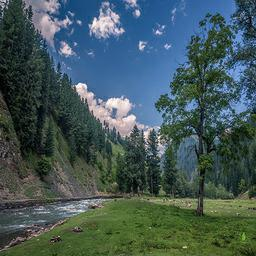

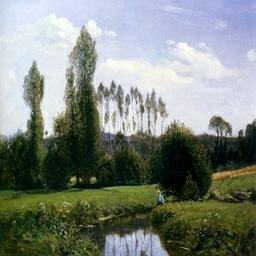

In [2]:
# Load images
content_image = "0cae98323f"
style_image = "8b841420b4"

base_path_content = "../../data/art/photo_jpg/"
base_path_style = "../../data/art/monet_jpg/"


content_image_path = base_path_content + content_image + ".jpg"
style_image_path = base_path_style + style_image + ".jpg"

display(Image(content_image_path))
display(Image(style_image_path))

In [78]:
# Make tf dataset from content images.
image_size = (256,256)
batch_size = 1


base_path_content = "../../data/art/photo_jpg/"
base_path_content = "../../data/art/test/"

#content_image_path = base_path_content + content_image + ".jpg"
train = keras.preprocessing.image_dataset_from_directory(
    base_path_content,
    validation_split=0.5,
    subset="training",
    labels=None,
    seed=1581,
    image_size=image_size,
    batch_size=batch_size
)


validation = keras.preprocessing.image_dataset_from_directory(
    base_path_content,
    validation_split=0.2,
    subset="validation",
    labels=None,
    seed=1581,
    image_size=image_size,
    batch_size=batch_size
)


Found 3 files belonging to 1 classes.
Using 2 files for training.
Found 3 files belonging to 1 classes.
Using 0 files for validation.


In [214]:
# Get dimension of image and set the dimension of the generated image.
width, height = keras.preprocessing.image.load_img(content_image_path).size

print(width, height)

256 256


In [24]:
# Preprocess and postprocess images
def preprocess_image_transform_net(full_image_path):
    """
    Transforms the input content image into the format required by
    the transformation network.

    Returns:
    Tensorflow tensor
    """
    # TODO: Implement after network is defined!
    return None


def postprocess_image_transform_net(image_as_tensor):
    """
    Transforms an image from the tensorflow tensor format into the format specified by the loss network.
    """
    # TODO: Finish implementation according to the requirements of the 
    # transform network.
    image = image_as_tensor.reshape((width, height, 3))
    # TODO: Remove some scaling or whatever maybe. Also maybe from BGR -> RGB.


    return image




def preprocess_image_loss_net(full_image_path):
    """
    Transforms the image at the path into a tensorflow tensor according to the 
    vgg16 requirements.

    Takes the style and conent images.
    """


    img = keras.preprocessing.image.load_img(full_image_path)
    img = keras.preprocessing.image.img_to_array(img)
    # Adds batch dimension. Shape is (batch, height, width, colour)
    img = np.expand_dims(img, axis=0)
    # Convert RGB to BGR and zero centre each colour channel according to ImageNet.
    # Does not perform scaling.
    img = vgg16.preprocess_input(img)
    # Convert to tensorflow tensor
    img = tf.convert_to_tensor(img)

    return img


In [5]:
img = keras.preprocessing.image.load_img(content_image_path)
img = keras.preprocessing.image.img_to_array(img)

# Adds batch dimension. Shape is (batch, height, width, colour)
img = np.expand_dims(img, axis=0)
# Convert RGB to BGR and zero centre each colour channel according to ImageNet.
# Does not perform scaling.
# Convert to tensorflow tensor
img = tf.convert_to_tensor(img)

# Define transform and loss networks

## Transform network
Use Keras Functional API to construct network, since we need the residual blocks.



## Loss network
Use pretrained VGG16.

In [118]:
# Create reflection padding layer
class ReflectionPadding2D(keras.layers.Layer):
    def __init__(self):
        super(ReflectionPadding2D, self).__init__()
    
    def call(self, inputs):
        paddings = tf.constant([[0,0],[40,40],[40,40],[0,0]]) # 40, 

        return tf.pad(inputs, paddings, "REFLECT")

In [136]:
# Residual block
def residual_block(n_filters, name, inputs, stride=(1,1)):
    x = layers.Conv2D(filters=n_filters, kernel_size=(3,3), strides=stride, activation="relu", name='Conv1ResidualBlock_' + name)(inputs)
    x = layers.BatchNormalization(scale=False)(x)

    x = layers.Conv2D(filters=n_filters, kernel_size=(3,3), strides=stride, name='Conv2ResidualBlock_' + name)(x)
    x = layers.BatchNormalization(scale=False)(x)

    # Crop the input to match sizes and add activations.
    inputs = tf.keras.layers.Cropping2D(cropping=((2,2),(2,2)), data_format=None)(inputs)
    x = layers.Add()([x, inputs])
    x = activations.relu(x)
    return x


# Test
x = tf.ones(shape=(1,84,84,128))
print(x.shape)

y = residual_block(128,"1", x)
print(y.shape)

(1, 84, 84, 128)
(1, 80, 80, 128)


In [137]:
### Transform network ###
def get_uncompiled_model():

    inputs = keras.Input(shape=(256,256,3), name="InputLayer")

    #print(inputs)
    # Reflection padding
    padding = ReflectionPadding2D()
    padding._name = "Reflection"
    x = padding(inputs)
   
    x = layers.Conv2D(filters=32, kernel_size=(9,9),strides=(1,1), activation="relu", padding='same', name="Conv1")(x)
    x = layers.BatchNormalization(scale=False)(x)

    x = layers.Conv2D(filters=64, kernel_size=(3,3),strides=(2,2), activation="relu", padding='same', name="Conv2")(x) 
    x = layers.BatchNormalization(scale=False)(x)

    x = layers.Conv2D(filters=128, kernel_size=(3,3),strides=(2,2), activation="relu", padding='same', name="Conv3")(x)
    x = layers.BatchNormalization(scale=False)(x)

    # Residual blocks
    x = residual_block(128,"1", x)
    x = residual_block(128,"2", x)
    x = residual_block(128,"3", x)
    x = residual_block(128,"4", x)
    x = residual_block(128,"5", x)

    # Deconvolutions
    x = layers.Conv2DTranspose(filters=64, kernel_size=(3,3), strides=(2,2), activation="relu", padding='same', name="Deconv1")(x)
    x = layers.BatchNormalization(scale=False)(x)

    x = layers.Conv2DTranspose(filters=32, kernel_size=(3,3), strides=(2,2), activation="relu", padding='same', name='Deconv2')(x)
    x = layers.BatchNormalization(scale=False)(x)

    x = layers.Conv2D(filters=3, kernel_size=(9,9), strides=(1,1), activation="tanh", padding='same', name="Conv4")(x)
    outputs = layers.BatchNormalization(scale=False)(x)

    return keras.Model(inputs=inputs, outputs=outputs, name="Transform_network")

In [80]:
#transform_network.summary()
#keras.utils.plot_model(transform_network, "Transform_network.png", show_shapes=True)

In [12]:
# Loss network
# Input: 224x224 -> Do I have to resize the input image from 256x256 or does the model not care?
loss_net = vgg16.VGG16(include_top=False, weights="imagenet", input_tensor=Input(shape=(256,256,3)))
loss_net_outputs = dict([(layer.name, layer.output) for layer in loss_net.layers])

loss_net_activations = keras.Model(inputs=loss_net.inputs, outputs=loss_net_outputs)

In [257]:
#loss_net.summary()

# Define loss function

In [13]:
# Hashtables: layer -> [height, width, channels]

style_layers = {
    "block1_conv2": [256,256,64],
    "block2_conv2": [128,128,128],
    "block3_conv3": [64,64,256],
    "block4_conv3" : [32,32,512]
}
content_layers = {"block3_conv3": [64,64,256]}

In [15]:
# Feature loss (content loss)

# Define input image shape
channels = 3
height = 256
width = 256

def compute_content_loss(generated, content, dimensions):
    """
    Computes the content loss from the given features.
    Equation 2 in paper.

    Args:
    generated:  Tensor feature map of the generated image.
    content:    Tensor feature map of the content image.
    dimensions: List of layer dimensions [height, width, channels]
    """

    height, width, channels = dimensions[0], dimensions[1], dimensions[2]
    scaling_factor = (int(height/4) * int(width/4) * channels) # H, W, C

    # Sum over all elements to get loss. Here the sum is over the squared euclidian norm.
    content_reconstruction_loss =  tf.math.reduce_sum(tf.square(generated - content)) / scaling_factor
    return content_reconstruction_loss


def gram_matrix(x):
    """
    Computes the gram matrix.
    y = xT * x
    """
    x = tf.transpose(x, (2,0,1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


def compute_style_loss(generated, style, dimensions):
    """
    Compute style loss for one layer.
    """
    
    # Dimensions
    height, width, channels = dimensions[0], dimensions[1], dimensions[2] 
    scaling_factor = (channels * height * width)**2

    generated = gram_matrix(generated)

    style = gram_matrix(style)
    res = tf.reduce_sum(tf.square(generated - style)) / scaling_factor
    return res



### TEST: Gram matrix
x = tf.ones(shape=(256,256,3)) # Colour image
y = gram_matrix(x)
print(x.shape, y.shape)

(256, 256, 3) (3, 3)


In [45]:

def compute_loss(generated_image, content_image, style_image):
    """
    Computes the loss with the loss network.
    """
    
    # Combine input tensors to make one pass with all in parallel.
    input_tensors = tf.concat([generated_image, content_image, style_image], axis=0)
    #print(generated_image.shape, content_image.shape, style_image.shape)
    #print(input_tensors.shape)
    #print("Shapes:")

    # Forward pass to get loss from loss network.
    features = loss_net_activations(input_tensors, training=False)

    # Initialize loss
    loss = tf.zeros(shape=())

    # Compute content loss
    for content_layer in content_layers.keys():
        layer_features = features[content_layer]
        generated_features = layer_features[0:,:,:]
        content_features = layer_features[1,:,:,:]
        loss += compute_content_loss(generated_features, content_features, content_layers[content_layer])
        #print(generated_features.shape, content_features.shape)

    # Compute style loss
    for style_layer in style_layers.keys():
        layer_features = features[style_layer]
        generated_features = layer_features[0,:,:,:]
        style_features = layer_features[2,:,:,:]
        loss += compute_style_loss(generated_features, style_features, style_layers[style_layer])
        #print(style_features.shape)


    return loss

In [5]:
def compute_pixel_loss(generated_image, content_image, style_image):
    

    return tf.reduce_sum(tf.square(content_image - generated_image))


## Build training loop


In [114]:
def get_test_model():
    inputs = keras.Input(shape=(256,256,3), name="InputLayer")
    
    x = layers.Conv2D(filters=32, kernel_size=(9,9), strides=(1,1), padding='same', name="Conv1")(inputs)
    x = activations.relu(x, name="ReLU1")
    x = layers.BatchNormalization(scale=False)(x)

    x = layers.Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding='same', name="Conv2")(x)
    x = activations.relu(x, name="ReLU2")
    x = layers.BatchNormalization(scale=False)(x)

    x = layers.Conv2DTranspose(filters=32, kernel_size=(3,3), strides=(2,2), padding='same', name="Deconv1")(x)
    x = activations.relu(x, name="ReLU11")
    x = layers.BatchNormalization(scale=False)(x)

    x = layers.Conv2DTranspose(filters=3, kernel_size=(9,9), strides=(1,1), padding='same', name="Deconv2")(x) 
    outputs = activations.tanh(x, name="tanh")
    x = layers.BatchNormalization(scale=False)(x)
    
    return keras.Model(inputs=inputs, outputs=outputs, name="Test_network")

test_model = get_test_model()
#test_model.summary()


In [145]:

transform_network = get_uncompiled_model()
#transform_network = get_test_model()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

epochs = 500


## Custom training loop from scratch

# Load style image
print("Loading style image...")
style_image_name = "8b841420b4"
#style_image = preprocess_image_loss_net("../../data/art/monet_jpg/"+style_image_name+".jpg")
style_image = None

for epoch in range(epochs):
    print("Running epoch %d / %d" %(epoch+1, epochs))
    for step, img in enumerate(train):
        # Scale image to range [0,1]
        img = img/255.0

        with tf.GradientTape() as tape:

            # Forward pass
            generated_image = transform_network(img, training=True)
           
            # Clip output generated_image to range [-1,1]
            generated_image = tf.clip_by_value(generated_image, -1.0, 1.0)

            # Get loss
            #loss = compute_loss(generated_image, img, style_image)
            loss = compute_pixel_loss(generated_image, img, style_image)

        # Update weights     
        grads = tape.gradient(loss, transform_network.trainable_weights)
        optimizer.apply_gradients(zip(grads, transform_network.trainable_weights))

        # Print current batch-wise loss
        if step % 10 == 0:
            print("Current loss for one batch at step {:.0f}: {:.2f}".format(step, loss))
            

Loading style image...
Running epoch 1 / 500
Current loss for one batch at step 0: 185242.00
Running epoch 2 / 500
Current loss for one batch at step 0: 139703.72
Running epoch 3 / 500
Current loss for one batch at step 0: 84689.66
Running epoch 4 / 500
Current loss for one batch at step 0: 56734.61
Running epoch 5 / 500
Current loss for one batch at step 0: 51256.07
Running epoch 6 / 500
Current loss for one batch at step 0: 46967.34
Running epoch 7 / 500
Current loss for one batch at step 0: 43680.79
Running epoch 8 / 500
Current loss for one batch at step 0: 41592.59
Running epoch 9 / 500
Current loss for one batch at step 0: 42444.94
Running epoch 10 / 500
Current loss for one batch at step 0: 37271.74
Running epoch 11 / 500
Current loss for one batch at step 0: 41229.64
Running epoch 12 / 500
Current loss for one batch at step 0: 40693.36
Running epoch 13 / 500
Current loss for one batch at step 0: 40185.04
Running epoch 14 / 500
Current loss for one batch at step 0: 32711.28
Runn

tf.Tensor(-0.56811774, shape=(), dtype=float32) tf.Tensor(0.8015983, shape=(), dtype=float32)
55.064987 229.70378


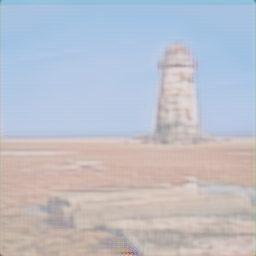

In [146]:
generated_image = transform_network(img, training=False)

# Show generated image
generated_image = generated_image.numpy()
x = ((generated_image * 0.5) + 0.5) * 255

x = x.reshape((256,256,3))
#x = x.reshape((336,336,3))

print(tf.math.reduce_min(generated_image), tf.math.reduce_max(generated_image))
print(x.min(),x.max())

test_out = ImagePIL.fromarray(np.uint8(x)).convert('RGB')
test_out

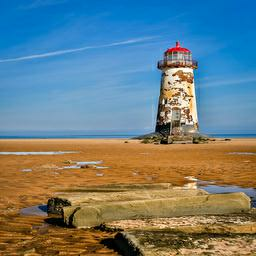

In [147]:

t = img.numpy()
t = t.reshape((256,256,3))
t = t * 255
t = ImagePIL.fromarray(np.uint8(t)).convert('RGB')
t
